### Autograd in Pytorch

In [1]:
import torch
# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
z = x ** 3
z.backward() #Computes the gradient 
print(x.grad.data) #Prints '3' which is dz/dx 

tensor(3.)


In [2]:
import torch

# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0)
z = x * y
z.backward()

print ("dz/dx=",y,x.grad.data)

dz/dx= tensor(2.) tensor(2.)


In [3]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = 3*a**3 - b**2
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

print (9*a**2)
print (a.grad.data)

tensor([True, True])
tensor([True, True])
tensor([36., 81.], grad_fn=<MulBackward0>)
tensor([36., 81.])


### Linear Regression

In [4]:
import numpy as np# create dummy data for training
x_values = [i for i in range(15)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

# y = 2*x + 1 

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

print (x_train.shape, y_train.shape)

import torch
from torch.autograd import Variable

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out
    
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 100

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))
    
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()
    print(predicted)



(15, 1) (15, 1)
tensor(266.6205, grad_fn=<MseLossBackward0>)
epoch 0, loss 266.6204528808594
tensor(36.0826, grad_fn=<MseLossBackward0>)
epoch 1, loss 36.0826416015625
tensor(4.8835, grad_fn=<MseLossBackward0>)
epoch 2, loss 4.883523464202881
tensor(0.6613, grad_fn=<MseLossBackward0>)
epoch 3, loss 0.6612833738327026
tensor(0.0899, grad_fn=<MseLossBackward0>)
epoch 4, loss 0.08987608551979065
tensor(0.0125, grad_fn=<MseLossBackward0>)
epoch 5, loss 0.01254273485392332
tensor(0.0021, grad_fn=<MseLossBackward0>)
epoch 6, loss 0.0020728560630232096
tensor(0.0007, grad_fn=<MseLossBackward0>)
epoch 7, loss 0.0006518066511489451
tensor(0.0005, grad_fn=<MseLossBackward0>)
epoch 8, loss 0.0004554498882498592
tensor(0.0004, grad_fn=<MseLossBackward0>)
epoch 9, loss 0.00042489200131967664
tensor(0.0004, grad_fn=<MseLossBackward0>)
epoch 10, loss 0.0004168048908468336
tensor(0.0004, grad_fn=<MseLossBackward0>)
epoch 11, loss 0.00041179361869581044
tensor(0.0004, grad_fn=<MseLossBackward0>)
epoch 

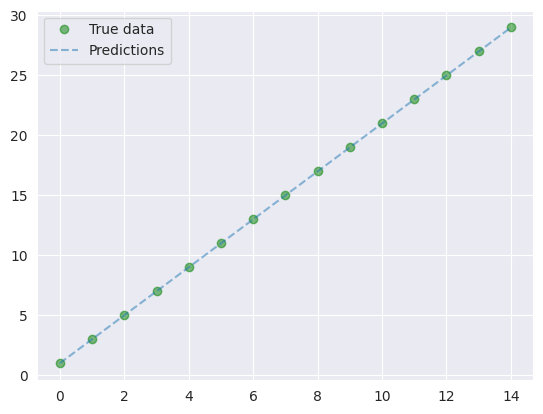

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

### Logistic regression

In [7]:
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import torch


matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
#params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
#plt.rcParams.update(params)

sns.set_style('darkgrid')


from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Generate a random dataset, but linearly separable!!!
separable = False
while not separable:
    samples = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, flip_y=-1)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    separable = any([red[:,k].max() < blue[:,k].min() or red[:,k].min() > blue[:,k].max() for k in range(2)])
    #print (separable)



plt.scatter(red[:,0], red[:,1], c='red', label='Class 0')
plt.scatter(blue[:,0], blue[:,1], c='blue', label='Class 1')
plt.show()

red_labels = np.zeros(len(red))
blue_labels = np.zeros(len(blue))

labels = np.append(red_labels, blue_labels)
inputs = np.concatenate((red, blue), axis=0)

print (inputs.shape)
print (labels.shape)
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(inputs, labels, test_size=0.3, random_state=42)


class LogisticRegression (torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out
    
epochs = 100000
input_dim = 2 # two features x1, x2
output_dim = 1
learning_rate = 0.01

model = LogisticRegression(input_dim, output_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_test).float()
y_val = torch.from_numpy(y_test).float()

losses = []
losses_val = []

iters = []

iter = 0

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), y_train)
    loss.backward()
    optimizer.step()
    iter += 1
    if iter % 10000 == 0:
        with torch.no_grad():
            
            outputs_val = model(X_val)
            loss_val = criterion(torch.squeeze(outputs_val), y_val)
            losses_val.append(loss_val.item())

            losses.append(loss.item())
            iters.append(iter)

            #print('Iteration: {}. Loss: {}. Val Loss: {}'.format(iter, loss.item(), loss_val.item()))

plt.clf()
plt.plot(iters, losses, label='Train Loss')
plt.plot(iters, losses_test, label='Validation Loss')
plt.legend(loc="upper left")
plt.show()

InvalidParameterError: The 'flip_y' parameter of make_classification must be a float in the range [0.0, 1.0]. Got -1 instead.

### Shallow neural network

In [9]:
# Necessary imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# This line detects if we have a gpu support on our system
device = ("cuda" if torch.cuda.is_available() else "cpu")

x1 = np.random.randn(2000)*0.5+3
x2 = np.random.randn(2000)*0.5+2

x3 = np.random.randn(2000) *0.5 + 4
x4 = np.random.randn(2000) *0.5 + 5

# Creating a Matrix
X_1 = np.vstack([x1, x2])
X_2 = np.vstack([x3, x4])
X = np.hstack([X_1, X_2]).T

# Creating a vector that contains classes (0, 1)
y = np.hstack([np.zeros(2000), np.ones(2000)])

print(X.shape)
print(y.shape)

plt.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm, edgecolors='w');
plt.title('Dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')

(4000, 2)
(4000,)


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# converting the datatypes from numpy array into tensors of type float
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)

y_train = torch.from_numpy(y_train.squeeze()).type(torch.FloatTensor).view(-1, 1)
y_test = torch.from_numpy(y_test.squeeze()).type(torch.FloatTensor).view(-1, 1)

# checking the shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([3200, 2])
torch.Size([800, 2])
torch.Size([3200, 1])
torch.Size([800, 1])


## Model definition

In [11]:
class ShallowNeuralNetwork(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(ShallowNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_num, hidden_num) # hidden layer
        self.output = nn.Linear(hidden_num, output_num) # output layer
        #self.sigmoid = nn.Sigmoid() # sigmoid activation function
        self.relu = nn.ReLU() # relu activation function
    
    def forward(self, x):
        x = self.relu(self.hidden(x)) 
        out = self.output(x)
        return out

input_num = 2
hidden_num = 2
output_num = 1 # The output should be the same as the number of classes

model = ShallowNeuralNetwork(input_num, hidden_num, output_num)
model.to(device) # send our model to gpu if available else cpu. 
print(model)

ShallowNeuralNetwork(
  (hidden): Linear(in_features=2, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
)


## Training cycle

In [12]:
!pip install tqdm
from tqdm import tqdm

criterion = torch.nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

if torch.cuda.is_available():
    X_train = Variable(X_train).cuda()
    y_train = Variable(y_train).cuda()
    X_test = Variable(X_test).cuda()
    y_test = Variable(y_test).cuda()

num_epochs = 1000



total_acc, total_loss = [], []

for epoch in tqdm(range(num_epochs)):
    # forward propagation
    model.train()

    y_pred = model(X_train)
    pred = np.where(y_pred.cpu() > 0.5, 1, 0)
    loss = criterion(y_pred, y_train)
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    


    print('Epoch [{}/{}], Train Loss: {:.5f},'.format(epoch, num_epochs, loss.item()))
print('\nTraining Complete')

Defaulting to user installation because normal site-packages is not writeable


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [0/1000], Train Loss: 1.43710,
Epoch [1/1000], Train Loss: 0.94556,
Epoch [2/1000], Train Loss: 0.78824,
Epoch [3/1000], Train Loss: 0.72738,
Epoch [4/1000], Train Loss: 0.69876,
Epoch [5/1000], Train Loss: 0.68298,
Epoch [6/1000], Train Loss: 0.67281,
Epoch [7/1000], Train Loss: 0.66518,
Epoch [8/1000], Train Loss: 0.65874,
Epoch [9/1000], Train Loss: 0.65286,
Epoch [10/1000], Train Loss: 0.64725,
Epoch [11/1000], Train Loss: 0.64177,
Epoch [12/1000], Train Loss: 0.63634,
Epoch [13/1000], Train Loss: 0.63091,
Epoch [14/1000], Train Loss: 0.62544,
Epoch [15/1000], Train Loss: 0.61992,
Epoch [16/1000], Train Loss: 0.61432,
Epoch [17/1000], Train Loss: 0.60863,
Epoch [18/1000], Train Loss: 0.60283,
Epoch [19/1000], Train Loss: 0.59691,
Epoch [20/1000], Train Loss: 0.59087,
Epoch [21/1000], Train Loss: 0.58470,
Epoch [22/1000], Train Loss: 0.57838,
Epoch [23/1000], Train Loss: 0.57192,
Epoch [24/1000], Train Loss: 0.56531,
Epoch [25/1000], Train Loss: 0.55856,
Epoch [26/1000], Train

 12%|█▏        | 115/1000 [00:00<00:01, 600.79it/s]

Epoch [32/1000], Train Loss: 0.50730,
Epoch [33/1000], Train Loss: 0.49948,
Epoch [34/1000], Train Loss: 0.49156,
Epoch [35/1000], Train Loss: 0.48355,
Epoch [36/1000], Train Loss: 0.47546,
Epoch [37/1000], Train Loss: 0.46731,
Epoch [38/1000], Train Loss: 0.45910,
Epoch [39/1000], Train Loss: 0.45086,
Epoch [40/1000], Train Loss: 0.44260,
Epoch [41/1000], Train Loss: 0.43433,
Epoch [42/1000], Train Loss: 0.42607,
Epoch [43/1000], Train Loss: 0.41783,
Epoch [44/1000], Train Loss: 0.40963,
Epoch [45/1000], Train Loss: 0.40148,
Epoch [46/1000], Train Loss: 0.39340,
Epoch [47/1000], Train Loss: 0.38539,
Epoch [48/1000], Train Loss: 0.37748,
Epoch [49/1000], Train Loss: 0.36967,
Epoch [50/1000], Train Loss: 0.36198,
Epoch [51/1000], Train Loss: 0.35441,
Epoch [52/1000], Train Loss: 0.34698,
Epoch [53/1000], Train Loss: 0.33969,
Epoch [54/1000], Train Loss: 0.33255,
Epoch [55/1000], Train Loss: 0.32557,
Epoch [56/1000], Train Loss: 0.31876,
Epoch [57/1000], Train Loss: 0.31211,
Epoch [58/10

 28%|██▊       | 284/1000 [00:00<00:00, 774.84it/s]

Epoch [181/1000], Train Loss: 0.09397,
Epoch [182/1000], Train Loss: 0.09360,
Epoch [183/1000], Train Loss: 0.09324,
Epoch [184/1000], Train Loss: 0.09287,
Epoch [185/1000], Train Loss: 0.09252,
Epoch [186/1000], Train Loss: 0.09216,
Epoch [187/1000], Train Loss: 0.09181,
Epoch [188/1000], Train Loss: 0.09146,
Epoch [189/1000], Train Loss: 0.09112,
Epoch [190/1000], Train Loss: 0.09078,
Epoch [191/1000], Train Loss: 0.09045,
Epoch [192/1000], Train Loss: 0.09012,
Epoch [193/1000], Train Loss: 0.08979,
Epoch [194/1000], Train Loss: 0.08946,
Epoch [195/1000], Train Loss: 0.08914,
Epoch [196/1000], Train Loss: 0.08882,
Epoch [197/1000], Train Loss: 0.08851,
Epoch [198/1000], Train Loss: 0.08819,
Epoch [199/1000], Train Loss: 0.08788,
Epoch [200/1000], Train Loss: 0.08758,
Epoch [201/1000], Train Loss: 0.08727,
Epoch [202/1000], Train Loss: 0.08697,
Epoch [203/1000], Train Loss: 0.08668,
Epoch [204/1000], Train Loss: 0.08638,
Epoch [205/1000], Train Loss: 0.08609,
Epoch [206/1000], Train L

 45%|████▌     | 452/1000 [00:00<00:00, 809.58it/s]

Epoch [362/1000], Train Loss: 0.05777,
Epoch [363/1000], Train Loss: 0.05764,
Epoch [364/1000], Train Loss: 0.05752,
Epoch [365/1000], Train Loss: 0.05741,
Epoch [366/1000], Train Loss: 0.05729,
Epoch [367/1000], Train Loss: 0.05717,
Epoch [368/1000], Train Loss: 0.05705,
Epoch [369/1000], Train Loss: 0.05693,
Epoch [370/1000], Train Loss: 0.05681,
Epoch [371/1000], Train Loss: 0.05670,
Epoch [372/1000], Train Loss: 0.05658,
Epoch [373/1000], Train Loss: 0.05646,
Epoch [374/1000], Train Loss: 0.05635,
Epoch [375/1000], Train Loss: 0.05623,
Epoch [376/1000], Train Loss: 0.05612,
Epoch [377/1000], Train Loss: 0.05600,
Epoch [378/1000], Train Loss: 0.05589,
Epoch [379/1000], Train Loss: 0.05578,
Epoch [380/1000], Train Loss: 0.05566,
Epoch [381/1000], Train Loss: 0.05555,
Epoch [382/1000], Train Loss: 0.05544,
Epoch [383/1000], Train Loss: 0.05532,
Epoch [384/1000], Train Loss: 0.05521,
Epoch [385/1000], Train Loss: 0.05510,
Epoch [386/1000], Train Loss: 0.05499,
Epoch [387/1000], Train L

 63%|██████▎   | 627/1000 [00:00<00:00, 843.37it/s]

Epoch [532/1000], Train Loss: 0.04196,
Epoch [533/1000], Train Loss: 0.04189,
Epoch [534/1000], Train Loss: 0.04182,
Epoch [535/1000], Train Loss: 0.04175,
Epoch [536/1000], Train Loss: 0.04168,
Epoch [537/1000], Train Loss: 0.04161,
Epoch [538/1000], Train Loss: 0.04153,
Epoch [539/1000], Train Loss: 0.04146,
Epoch [540/1000], Train Loss: 0.04139,
Epoch [541/1000], Train Loss: 0.04132,
Epoch [542/1000], Train Loss: 0.04125,
Epoch [543/1000], Train Loss: 0.04118,
Epoch [544/1000], Train Loss: 0.04111,
Epoch [545/1000], Train Loss: 0.04104,
Epoch [546/1000], Train Loss: 0.04097,
Epoch [547/1000], Train Loss: 0.04090,
Epoch [548/1000], Train Loss: 0.04084,
Epoch [549/1000], Train Loss: 0.04077,
Epoch [550/1000], Train Loss: 0.04070,
Epoch [551/1000], Train Loss: 0.04063,
Epoch [552/1000], Train Loss: 0.04056,
Epoch [553/1000], Train Loss: 0.04049,
Epoch [554/1000], Train Loss: 0.04042,
Epoch [555/1000], Train Loss: 0.04036,
Epoch [556/1000], Train Loss: 0.04029,
Epoch [557/1000], Train L

 80%|████████  | 800/1000 [00:01<00:00, 833.47it/s]

Epoch [701/1000], Train Loss: 0.03209,
Epoch [702/1000], Train Loss: 0.03204,
Epoch [703/1000], Train Loss: 0.03199,
Epoch [704/1000], Train Loss: 0.03195,
Epoch [705/1000], Train Loss: 0.03190,
Epoch [706/1000], Train Loss: 0.03185,
Epoch [707/1000], Train Loss: 0.03181,
Epoch [708/1000], Train Loss: 0.03176,
Epoch [709/1000], Train Loss: 0.03171,
Epoch [710/1000], Train Loss: 0.03167,
Epoch [711/1000], Train Loss: 0.03162,
Epoch [712/1000], Train Loss: 0.03158,
Epoch [713/1000], Train Loss: 0.03153,
Epoch [714/1000], Train Loss: 0.03149,
Epoch [715/1000], Train Loss: 0.03144,
Epoch [716/1000], Train Loss: 0.03139,
Epoch [717/1000], Train Loss: 0.03135,
Epoch [718/1000], Train Loss: 0.03130,
Epoch [719/1000], Train Loss: 0.03126,
Epoch [720/1000], Train Loss: 0.03121,
Epoch [721/1000], Train Loss: 0.03117,
Epoch [722/1000], Train Loss: 0.03112,
Epoch [723/1000], Train Loss: 0.03108,
Epoch [724/1000], Train Loss: 0.03103,
Epoch [725/1000], Train Loss: 0.03099,
Epoch [726/1000], Train L

100%|██████████| 1000/1000 [00:01<00:00, 804.28it/s]

Epoch [872/1000], Train Loss: 0.02545,
Epoch [873/1000], Train Loss: 0.02541,
Epoch [874/1000], Train Loss: 0.02538,
Epoch [875/1000], Train Loss: 0.02535,
Epoch [876/1000], Train Loss: 0.02532,
Epoch [877/1000], Train Loss: 0.02529,
Epoch [878/1000], Train Loss: 0.02526,
Epoch [879/1000], Train Loss: 0.02523,
Epoch [880/1000], Train Loss: 0.02519,
Epoch [881/1000], Train Loss: 0.02516,
Epoch [882/1000], Train Loss: 0.02513,
Epoch [883/1000], Train Loss: 0.02510,
Epoch [884/1000], Train Loss: 0.02507,
Epoch [885/1000], Train Loss: 0.02504,
Epoch [886/1000], Train Loss: 0.02501,
Epoch [887/1000], Train Loss: 0.02498,
Epoch [888/1000], Train Loss: 0.02495,
Epoch [889/1000], Train Loss: 0.02492,
Epoch [890/1000], Train Loss: 0.02488,
Epoch [891/1000], Train Loss: 0.02485,
Epoch [892/1000], Train Loss: 0.02482,
Epoch [893/1000], Train Loss: 0.02479,
Epoch [894/1000], Train Loss: 0.02476,
Epoch [895/1000], Train Loss: 0.02473,
Epoch [896/1000], Train Loss: 0.02470,
Epoch [897/1000], Train L

In [13]:
model.eval()
model_prediction = model(X_test)

model_prediction = np.where(model_prediction.cpu() > 0.5, 1, 0)
model_prediction = model_prediction.reshape(-1)
print("Accuracy Score on test data ==>> {}%".format(accuracy_score(model_prediction, y_test.cpu()) * 100))


y_test = y_test.cpu()
X_test = X_test.cpu()
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
y_test = y_test.view(-1)

# True Predictions
ax[0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='Class 0', cmap=cm.coolwarm)
ax[0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='Class 1', cmap=cm.coolwarm)
ax[0].set_title('Actual Predictions')
ax[0].legend()

# Models Predictions
ax[1].scatter(X_test[model_prediction==0, 0], X_test[model_prediction==0, 1], label='Class 0', cmap=cm.coolwarm)
ax[1].scatter(X_test[model_prediction==1, 0], X_test[model_prediction==1, 1], label='Class 1', cmap=cm.coolwarm)
ax[1].set_title('Our Model Predictions')
ax[1].legend()

Accuracy Score on test data ==>> 99.75%


/tmp/ipykernel_7799/3770268992.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='Class 0', cmap=cm.coolwarm)
/tmp/ipykernel_7799/3770268992.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='Class 1', cmap=cm.coolwarm)
/tmp/ipykernel_7799/3770268992.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(X_test[model_prediction==0, 0], X_test[model_prediction==0, 1], label='Class 0', cmap=cm.coolwarm)
/tmp/ipykernel_7799/3770268992.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(X_test[model_prediction==1, 0], X_test[model_prediction==1, 1], label='Class 1', cmap=cm.coolwarm)


Error in callback <function _draw_all_if_interactive at 0x7a77a58279a0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1200x1000 with 2 Axes>